<img src=https://tongqu.sjtu.edu.cn/upload/acts/20210924/origin_dd931568c643595e7681ad95819dfca9.jpg alt="Ubiquant" width="80%" class="center"/>

# DSI Program 2022 Module 2 
# Team C DSI-FCANS

# 📚 Introduction
The forecasting of investment returns and other market related metrics is of great interest to financial institutions. Given the complexity and volatility of the financial markets, machine learning appears to provide promising tool to perform these forecasting tasks. 

This notebook gives a detailed summary of the work done toward the submissions made to the Kaggle completion [Ubiquant market prediction](https://www.kaggle.com/c/ubiquant-market-prediction). Ubiquant Investment (Beijing) Co., Ltd, founded in 2012, is a hedge fund based in China that uses a quantitative approach to trading. The goal of this competition is to use anonymized data, provided by Ubiquant, to predict a target value. This data consists of 300 features recorded over time relating to a large number of investments. Submissions made to the competition are ranked by their Pearson correlation to the true target values. 

In section 1 we provide exploratory data analysis and discuss how to cluster the investments using two different methods. In section 2 we discuss the three different approaches tested during the course of this module. In section 3 we briefly discuss the results we achieved on the Kaggle leader board and finally in section 4 we present our concluding remarks.

Our gihub reposistory can be found [here](https://github.com/AmyRouillard/DSI-FCANS).

In [1]:
# Hidden
import numpy as np
import pandas as pd 

from tqdm import tqdm
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from scipy.stats.stats import pearsonr 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Adjust figure font sizes for better appearance
plt.rc('font', size=16) #controls default text size
plt.rc('axes', titlesize=18) #fontsize of the title
plt.rc('axes', labelsize=16) #fontsize of the x and y labels
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend

# 📈 1. Exploratory Data Analysis

The dataset provided for this competition is very large, approximately 18.55 GB, and consists of time series data relating to 3579 unique investments, referred to by their "investment IDs". Associated with each investment is a set of time dependant data comprising 300 anonymised features and 1 target value.  Each time is referred to by a time ID. These time IDs are ordered however, the real time between the time IDs may not be constant. We are also warned in the completion documentation that time between time IDs will likely be shorter for the final private test set than in the training set.

## 1.1 Missing temporal information

One of the challenges associated with this dataset is that there are gaps, of varying length and at various points, in the time domain of the data. In addition, these gaps vary for different investments. The following three figures give a detailed impression of the extent of these time gaps. Notably, there is a pronounced gap in the vicinity of the time ID 400. This is visible in both the plot showing the number of unique investments recorded at a given time and the heatmap showing missing data. 

The figure showing the distribution of time-IDs shows that the number of available time IDs per investment varies greatly. The minimum number of time IDs available for an investment is 2, with 96 investments having less than 200 time-IDs recorded. The maximum number of time IDs available for an investment is 1211, with 1831 investments, approximately half of all investments, having greater than 1000 time IDs recorded.

In [2]:
# Training data is loaded from parquet format to save time
df_train_input = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')
df_train = df_train_input.sort_values(by=['investment_id','time_id'])

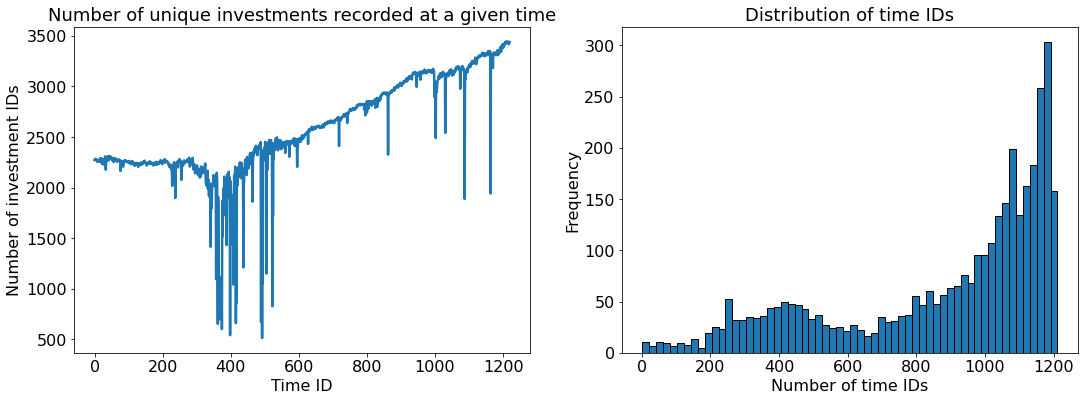

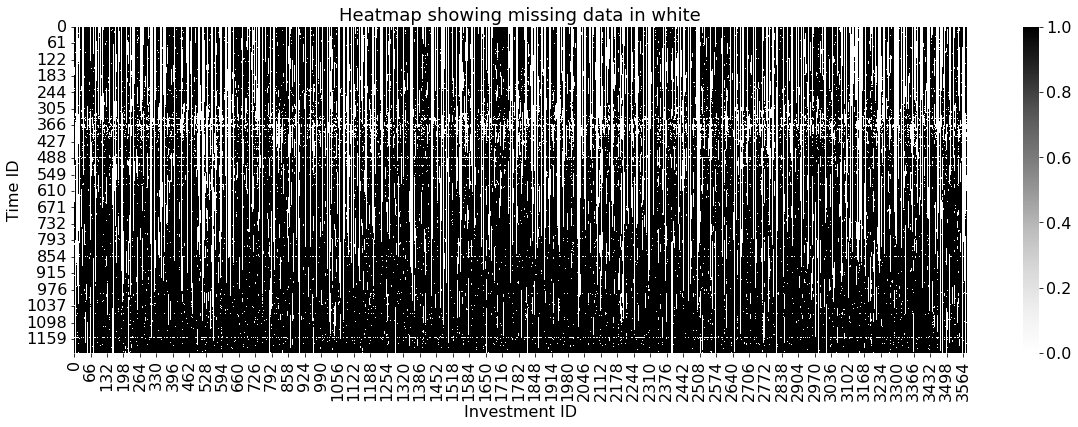

In [3]:
# Hidden
fig, ax = plt.subplots(1,2,figsize=(18, 6))
df_train.groupby('time_id')['investment_id'].nunique().plot(linewidth = 2.5, ax = ax[0])
ax[0].set_title("Number of unique investments recorded at a given time")
ax[0].set_xlabel("Time ID")
ax[0].set_ylabel('Number of investment IDs')

df_train.groupby(['investment_id'])['target'].count().plot.hist(bins=60, edgecolor="k", ax = ax[1])
ax[1].set_title("Distribution of time IDs")
ax[1].set_xlabel('Number of time IDs')
plt.show()


df_new = df_train[['investment_id','time_id','target']].pivot(index='time_id', columns ='investment_id', values='target')

plt.figure(figsize=(20, 6))
ax = sns.heatmap(1-np.isnan(df_new.to_numpy()), cmap="Greys")
plt.title('Heatmap showing missing data in white')
plt.xlabel('Investment ID')
plt.ylabel('Time ID')
plt.show()


## 1.2 Auto-correlations and partial auto-correlations

In this section we investigate auto-correlations and partial auto-correlations present in the target and feature variables. For a randomly selected investment the auto-correlations and partial auto-correlations are plotted for the target variable and for a randomly chosen feature. It is clear that there are little to no significate auto-correlations for the target variable. This suggests that the value of the target over time resembles a random walk. On the other hand, the feature appears to have significant auto-correlations as well as partial auto-correlations. This result suggests that the future value of the target depends mostly on the features and has little dependence on its historical value. 

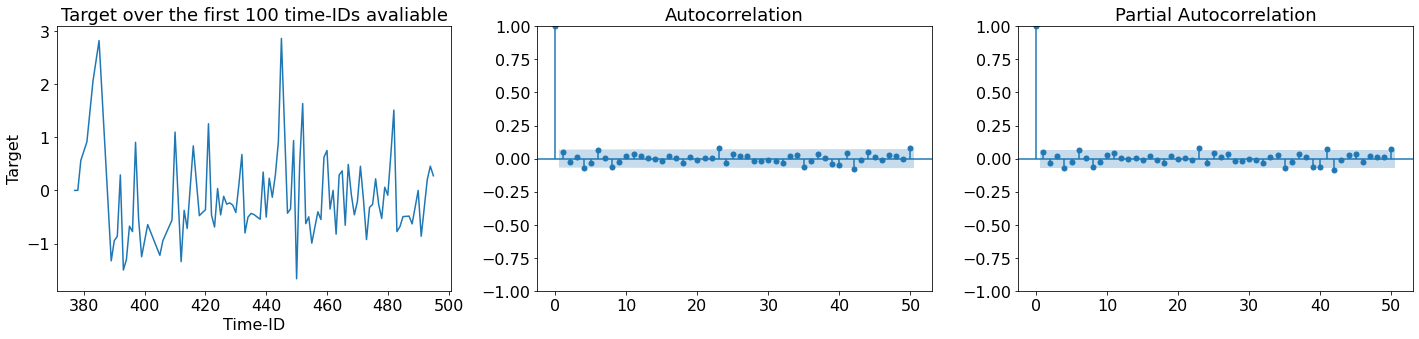

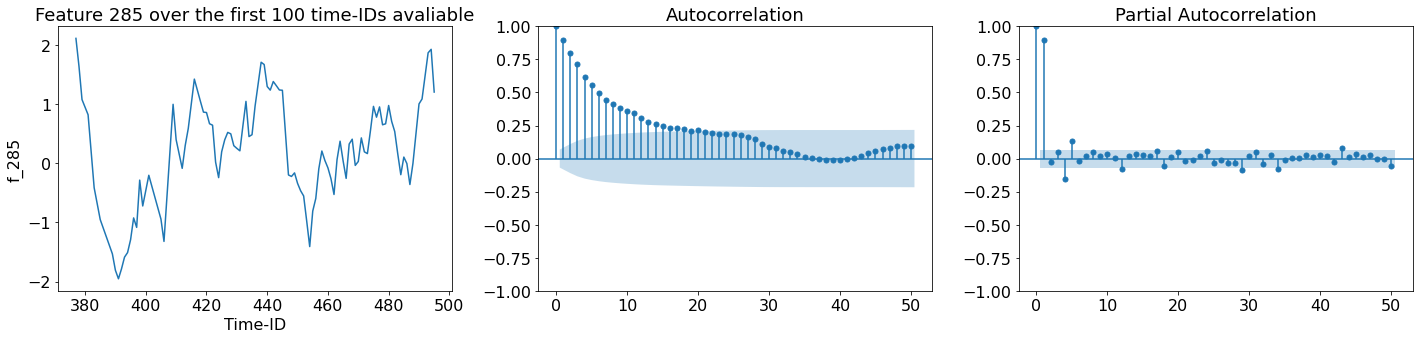

In [4]:
# Hidden
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 
import statsmodels.api as sm


inv_ids = df_train.investment_id.unique()

inv_id = random.choice(df_train.investment_id.unique())

fig, ax = plt.subplots(1,3,figsize=(20,5))

ax[0].plot(df_train.time_id.loc[df_train.investment_id==inv_id][0:100],df_train.target.loc[df_train.investment_id==inv_id][0:100])
ax[0].set_xlabel('Time-ID')
ax[0].set_ylabel('Target')
ax[0].set_title('Target over the first 100 time-IDs avaliable')

sm.graphics.tsa.plot_acf(df_train['target'].loc[df_train.investment_id==inv_id].to_numpy(), lags=50, ax=ax[1])#, zero = False
sm.graphics.tsa.plot_pacf(df_train['target'].loc[df_train.investment_id==inv_id].to_numpy(), lags=50, ax=ax[2])#, zero = False
fig.tight_layout()
plt.show()

feature = str(random.randint(0, 299))

fig, ax = plt.subplots(1,3,figsize=(20,5))

ax[0].plot(df_train.time_id.loc[df_train.investment_id==inv_id][0:100],df_train['f_'+feature].loc[df_train.investment_id==inv_id][0:100])
ax[0].set_xlabel('Time-ID')
ax[0].set_ylabel('f_'+feature)
ax[0].set_title('Feature '+feature+' over the first 100 time-IDs avaliable')

sm.graphics.tsa.plot_acf(df_train['f_'+feature].loc[df_train.investment_id==inv_id].to_numpy(), lags=50, ax=ax[1])#, zero = False
sm.graphics.tsa.plot_pacf(df_train['f_'+feature].loc[df_train.investment_id==inv_id].to_numpy(), lags=50, ax=ax[2])#, zero = False

fig.tight_layout()
plt.show()

## 1.3 Clustering 

Given the large number of investment IDs, it is not feasible to train a model for each investment. One approach is to group or cluster "similar" investments in order to reduce the number of models. 

### Clustering of investments using the Pearson correlation

Here we show how to group investments by their pair-wise correlation, thereby putting investments that are positively correlated into the same group. If there is no overlapping temporal information for two investments the correlation cannot be calculated. This occurs for several investment pairs as a result of missing time IDs. In order to overcome is problem we first drop a large portion of time IDs and retain only the last 55 timesteps. We then drop investments which have 10 or more time ID gaps. This means that in total we will ignore 216 investments. These investments should be added to an appropriate cluster later during data processing. This approach avoids using interpolation which could lead to incorrect clustering. 
Now that the number of time gaps has been greatly reduced, as show bellow, it is possible to compute the pair-wise Pearson correlation between all investment. The resulting correlation matrix is then used to compute a distance measure followed by the linkage matrix. The function 'fcluster' from the 'scipy.cluster.hierarchy' library  is then used to determine an appropriate clustering of the investments.  Depending on the chosen value of the ‘distance’ parameter, more or fewer clusters will be formed. Bellow we show how the number of clusters changes as this threshold is increased.


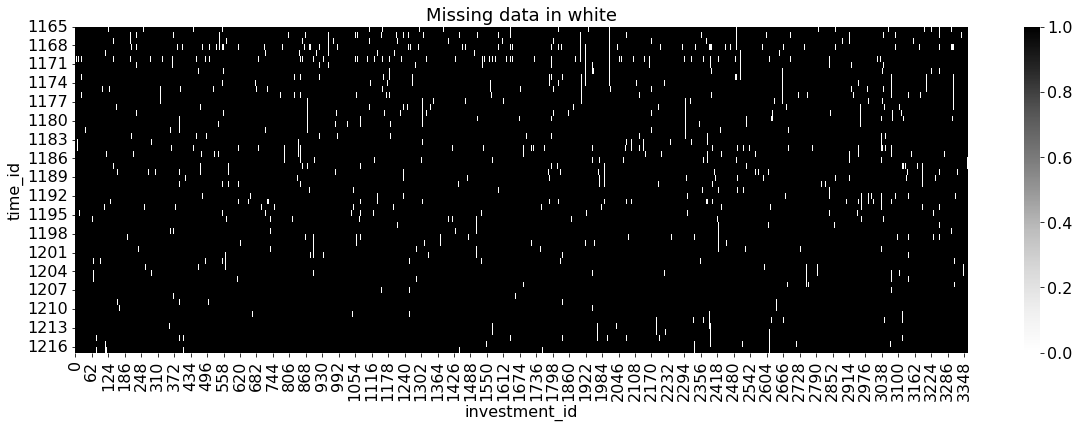

In [5]:
# Hidden
df_time_drop=df_new.drop(df_new.index[range(0,1156)])

N_missing = 10
df_time_drop = df_time_drop.dropna(thresh=len(df_time_drop)-N_missing, axis=1)

corr = df_time_drop.corr(method='pearson').values

plt.figure(figsize=(20,6))
ax = sns.heatmap(1-np.isnan(df_time_drop.to_numpy()), cmap="Greys")

plt.title('Missing data in white')
plt.xlabel('investment_id')
plt.ylabel('time_id')
plt.yticks(np.linspace(0,54,18),df_time_drop.index[:-1:3])
plt.show()

import scipy.cluster.hierarchy as spc

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')

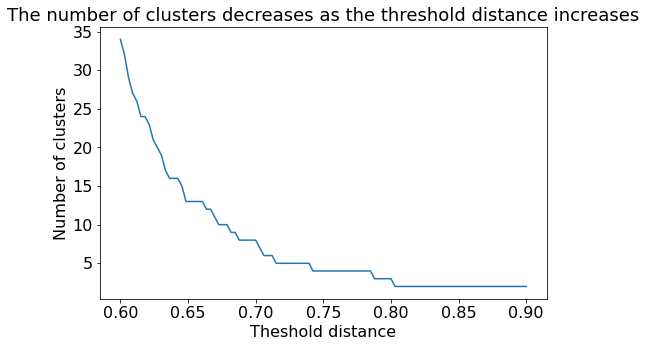

In [6]:
# Hidden
num_clusters = []
T =  np.linspace(0.6,0.9,100)
for t in T:
    idx = spc.fcluster(linkage, t * pdist.max(), 'distance')
    num_clusters.append(max(idx))

plt.figure(figsize=(8,5))
plt.plot(T,num_clusters)
plt.title('The number of clusters decreases as the threshold distance increases')
plt.ylabel('Number of clusters')
plt.xlabel('Theshold distance')
plt.show()
         

We can now choose a specific threshold distance value and visualise the how the investments are clustered. The left heatmap shows the pair-wise Pearson correlation. The figure on the right shows the same heatmap after the investments have been sorted according to their clusters. 

In [7]:
# Choose a threshold
threshold = 0.75

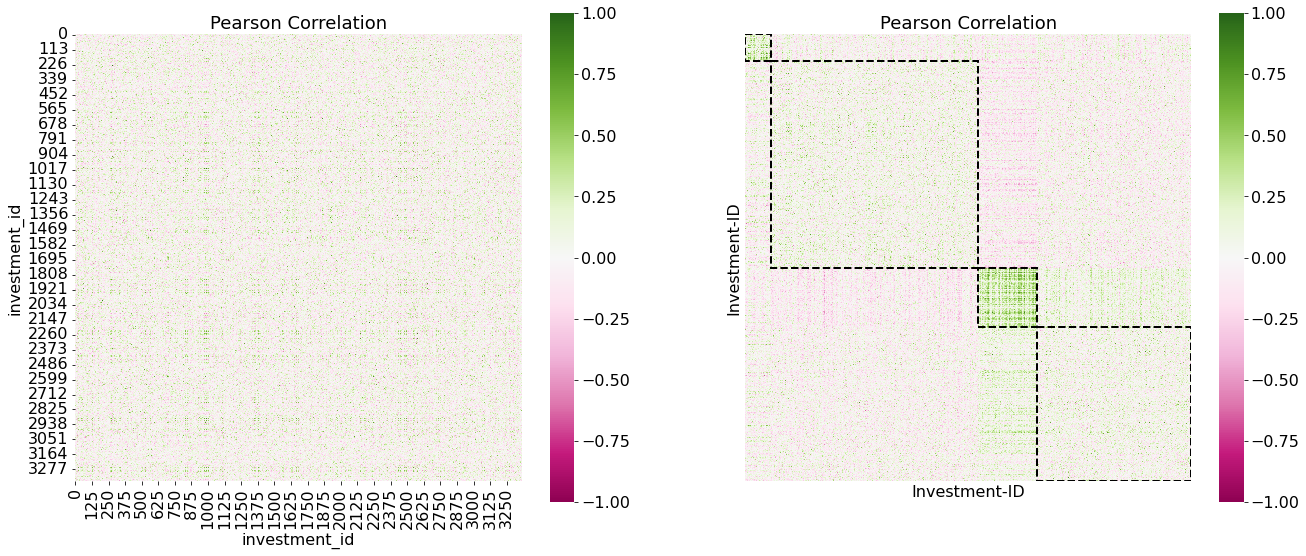

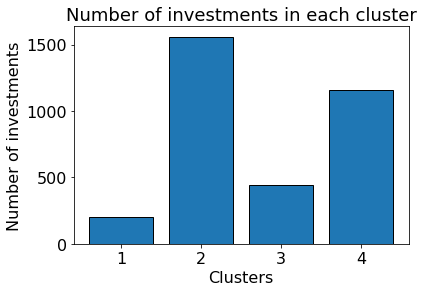

In [8]:
# Hidden 
idx = spc.fcluster(linkage, threshold * pdist.max(), 'distance')

_ , freq = np.unique(idx, return_counts=True)

columns = [df_time_drop.columns.tolist()[i] for i in list((np.argsort(idx)))]
df_sorted = df_time_drop.reindex(columns, axis=1)

from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1,2,figsize=(22,9))
# Not clustered
sns.heatmap(corr,cmap="PiYG", vmin=-1, vmax=1, ax = ax[0])
ax[0].set_title('Pearson Correlation')
ax[0].set_xlabel('investment_id')
ax[0].set_ylabel('investment_id')
ax[0].set_aspect('equal', adjustable='box')
# Clustered
sns.heatmap(df_sorted.corr().values,cmap="PiYG", vmin=-1, vmax=1,  ax = ax[1])
ax[1].set_aspect('equal', adjustable='box')
mean_corr = []
x_min=0
y_min=0
for i in range(len(freq)):
    width = freq[i]
    height = freq[i]
    ax[1].add_patch(Rectangle((x_min, y_min),
                            width, height,
                            fc='none',
                            color ='black',
                            linewidth = 2,
                            linestyle="dashed"))
    x_min+= freq[i]
    y_min+= freq[i]

ax[1].set_title('Pearson Correlation')
ax[1].set_xlabel('Investment-ID')
ax[1].set_ylabel('Investment-ID')
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

# Bar graph
plt.figure(figsize = (6,4))
labels, counts = np.unique(idx, return_counts=True)
plt.bar(labels, counts, edgecolor="k")
plt.ylabel('Number of investments')
plt.xlabel('Clusters')
plt.title('Number of investments in each cluster')
plt.show()

### Clustering Using Kmeans

In [9]:
# Hidden
# Pivot the investment IDs and target

train = df_train_input
table = pd.pivot_table(train, values='target', index = "investment_id",  columns = ["time_id"])
table.head()

time_id,0,1,2,3,4,5,6,7,8,9,...,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219
investment_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.472723,-0.236285,-2.621014,0.129619,1.138975,0.579622,0.064896,2.204664,1.037581,-2.631323
1,-0.300875,-0.917045,-0.480234,-0.323562,2.494479,0.299347,-1.381707,0.913922,-0.661152,-0.867373,...,0.072360,-0.071978,0.135815,0.226359,-0.167262,0.078338,-0.290113,-0.097136,-0.080295,0.656833
2,-0.231040,-0.472108,-0.661659,-0.055215,0.341267,-1.179242,-0.644588,-0.581904,-0.659482,-0.080913,...,-0.002608,-0.254329,-0.411340,0.169154,0.187624,-0.361899,-0.688692,0.007041,-0.082326,0.032135
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.269154,1.305137,0.280275,2.222628,1.267150,1.624498,-0.070665,1.532567,0.384600,0.401314
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.737825,0.373363,-0.896088,0.563158,0.411833,0.968079,-0.514005,-0.207239,0.318535,-0.060477


In [10]:
# Get target values
table = table.reset_index()
y = table.iloc[:,1:].values

In [11]:
# Interpolate target missing values using KNN

imputer = KNNImputer(n_neighbors=2, weights="uniform")
y = imputer.fit_transform(y)

In [12]:
# Check optimum number of clusters using elbow method

sse = {}
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, random_state=1)
    scaler = StandardScaler()
    y_std = scaler.fit_transform(y)
    kmeans.fit(y_std)
    sse[k] = kmeans.inertia_
    


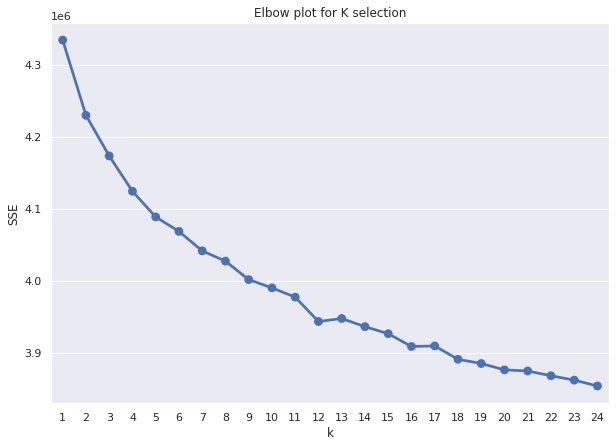

In [13]:
sns.set()
fig, ax = plt.subplots(figsize = (10,7))
sns.pointplot(x=list(sse.keys()),
                 y=list(sse.values()), ax = ax)
plt.title('Elbow plot for K selection')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

In [14]:
# Define the model
model = KMeans(n_clusters=10)

# Fit the model
kmeans = KMeans(n_clusters=k, random_state=1)
scaler = StandardScaler()
y_std = scaler.fit_transform(y)
model.fit(y_std)

# Assign a cluster to each example
yhat = model.predict(y_std)
# retrieve unique clusters
clusters = np.unique(yhat)

In [15]:
# Create clustered dataframe

clustered_df = pd.DataFrame({"id": table.investment_id.values, "cluster": yhat, "target": y.tolist()})
clustered_df.to_parquet("clustered.parquet")
clustered_df.head()

,id,cluster,target
0,0,6,"[-0.5021969079971313, 0.1758366823196411, 0.10..."
1,1,8,"[-0.3008749186992645, -0.9170452952384949, -0...."
2,2,8,"[-0.2310400903224945, -0.4721081554889679, -0...."
3,3,3,"[0.7823927402496338, 0.4705675542354584, 0.585..."
4,4,8,"[-0.6987646818161011, -0.483672171831131, 0.05..."


#### Check correlation of targets in clusters

In [16]:
# Hidden

def get_correlations(cluster):
    '''computes the correlation coefficient between two random 
    invenstment_ids.
    
    Parameters
    ----------
    cluster: single integer representing cluster in dfdataframe
    repeat_times: number of times to repea the random sampling in single cluster
    
    Returns
    -------
    corr[0]: pearson correlation coefficient of the two targets
    '''
    
    cluster_filt = clustered_df[clustered_df["cluster"] == cluster].copy()

    #sample two random investment IDs
    cluster_filt = cluster_filt.sample(n=2, axis = 0)
    signal_1 = np.asarray(cluster_filt.target.iloc[0])
    signal_2 =  np.asarray(cluster_filt.target.iloc[1])
    corr = pearsonr(signal_1,signal_2)
    
    return corr[0]

def plot_cluster_corr(cluster,repeat_times):
    '''computes the correlation coefficient between two random invenstment_ids
    in the cluster and saves figure.
    
    Parameters
    ----------
    cluster: single integer representing cluster in dfdataframe
    repeat_times: number of times to repea the random sampling in single cluster
    
    Returns
    -------
    None
    
    '''
    correlations=[]
    for i in range(0,repeat_times):     
        corr = get_correlations(cluster)
        correlations.append(corr)
    #fig, ax = plt.subplots(figsize=(5,5))
    plt.rc('font', size=15)
    plt.rc('axes', titlesize=15)
    ax = sns.displot(x=correlations)
    plt.title("cluster_"+ str(cluster))
    plt.savefig("cluster_"+ str(cluster)+".png", bbox_inches='tight')
    plt.ioff()
    return None

In [17]:
%%capture
# Hidden
cluster_list = list(clustered_df.cluster.unique())
cluster_list.sort()
for i,cluster in enumerate(cluster_list):
    plot_cluster_corr(cluster,500)
    


ValueError: Cannot take a larger sample than population when 'replace=False'

FileNotFoundError: [Errno 2] No such file or directory: 'cluster_9.png'

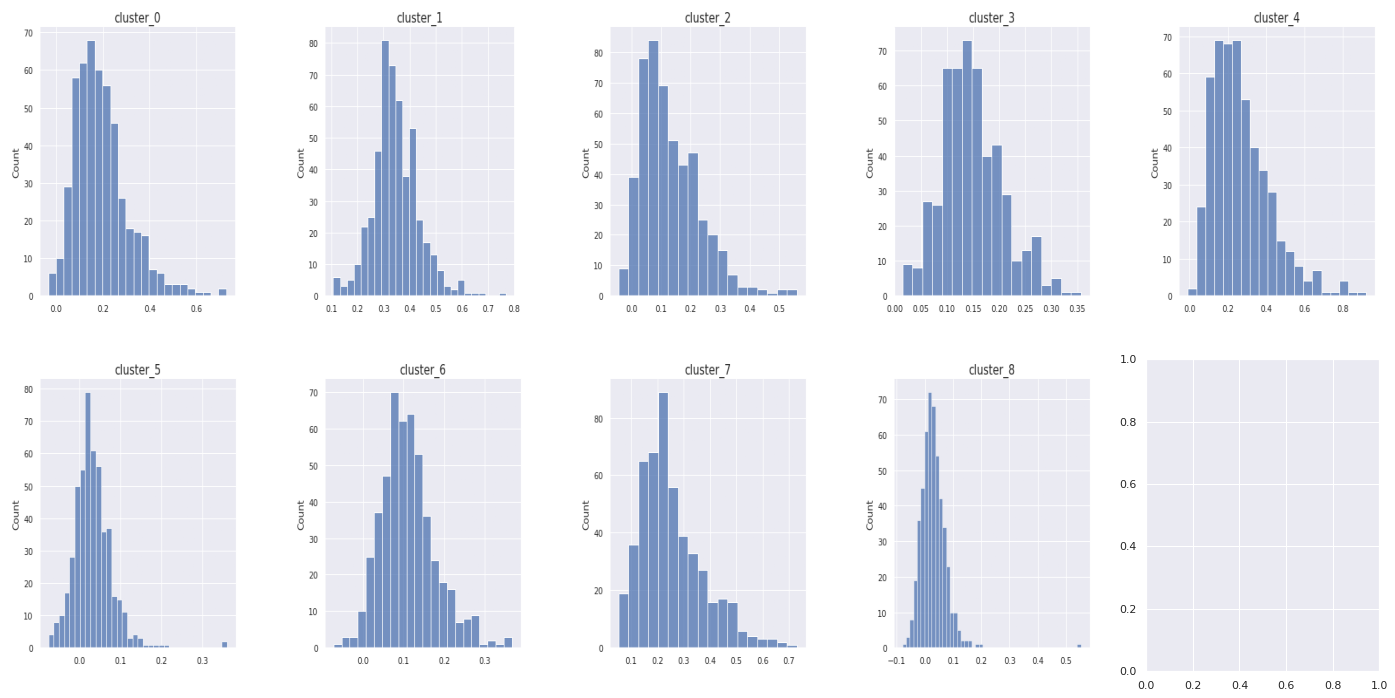

In [18]:
# Hidden
fig, ax = plt.subplots(2,5, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i,cluster in enumerate(cluster_list):
    image= plt.imread("cluster_"+ str(cluster)+".png")
    ax[i].imshow(image,aspect='auto')
    ax[i].axis('off')
    
    

### Kmeans Clustering Conclusion

As can be seen from the above figures, there seems to be some success in grouping certain investments. However, the different time samples for each time_id make clustering very difficult. As will be seen in the modelling section, an integer lookup scheme with categorical embedding was used instead of making use of cluster information for the training.


# 🛠 2 Approaches

In this section we discuss three different approaches attempted during this module. The first approach used an ensemble of deep neural networks (DNNs) and was the method which achieved the highest score on the public leader board. The second approach employs a multi-variate long short-term memory model and performed the worst on the public leader board. The final approach discussed here is Light Gradient Boosting Machine. This method achieved moderate results on the public leader board but was ultimately abandoned in favour of the DNN ensemble.



## 2.1 Approach 1: Deep Neural Network ensemble

Here we discuss how our main model is constructed. We utilize three different DNN model architectures in order to create an ensemble of models. Each model has several folds, each of which is incorporated into the final ensemble. The final prediction of the target value is made by taking **the mean** of all predictions made by the models in the ensemble. The schematic below provides an overview of this approach and a summary of the number of folds of each model created, the number of dense and dropout layers compised in each model and the number of training epochs that were used for each model.

<img src=https://raw.githubusercontent.com/AmyRouillard/DSI-FCANS/main/images/Ensemble_Model_Description.drawio.png alt="Ubiquant" width="60%" class="center"/>

Although each model differs in the number and ordering of dense and dropout layers, the overall structure of all three models remains the same. Each model combines a lookup layer with a second **...** input layer. The lockup layer plays the important role of distinguishing between the many investments, which form a categorical variable, while the second input layer handles the 300 feature variables.

### Model 1

Model 1 was trained on the ubiquant dataset using stratified cross validation (5 folds). 

We use StratifiedKFold to split our dataset into 5 folds, select one fold as validation set and train model with early stopping using the remaining 4 folds as a training set. We then used this model to predict outcomes for test set and record the predictions. Repeat 5 times, so that every fold plays the role of validation set at least once.

The model architecture is a multi input keras network with two input branches. First branch handles investment IDs (categorical feature) while the second branch will handle the remaining 300 anonymalized features (numeric features).

The model architecture will include an integer look up layer to process investment IDs before concatenating the feature with the 300 ananonymized features in the network. A integer lookup layer is a preprocessing layer which maps integer features to contiguous ranges. It turns integer categorical values into an encoded representation that can be read by an Embedding layer or Dense layer.

Having a lookup layer enables the keras deep learning model to handle both categorical and numeric features.

#### Model Architecture

[Architecture Figure](https://github.com/AmyRouillard/DSI-FCANS/blob/development/images/model%201%20architecture.png)

#### Model Hyper Parameters

|Hyper Parameter| |Value|
|---------------| |------------|
|Activation function| |Swish|
|Optimizer||Adam|
|Learning Rate||0.001|
|Loss Function| |MSE|
|Epochs||20|

#### Model Metrics

From the table below the ensemble seems to have a decent perfomance with an average MSE of 0.7912. On average the correlation coefficient between the predicted values and the actual values is 0.1228 across the 5 folds.

|Fold| |MSE| |Pearson-corr|
|----| |---| |------------|
|1| |0.7886||0.1228|
|2| |0.7848||0.1273|
|3| |0.7853||0.1283|
|4| |0.7920||0.1152|
|5| |0.8055||0.1206|

#### Model 1 Submission Score

The Model 1 comprising 5 models had a kaggle submission score of **0.149**.

#### Notebook link model 1

The notebook on ensemble 1 training and details can be found [Ensemble 1 Notebook](https://github.com/AmyRouillard/DSI-FCANS/blob/main/notebooks/dnn-base-model-1.ipynb).

### Model 2:

Model 2 is trained on the ubiquant dataset using stratified cross validation (10 folds).

The model architecture is a multi input keras network with 2 input branches. First branch handles investment Ids (categorical feature) while the second branch will handle remaining anonymalized 300 features (numeric features).

The architecture will include an integer lookup layer to process investment_ids before concatenating the feature with the 300 ananonymized features in the network similar to model 1 above.

This model architecture closely resembles the model 1 architecture but has additional dense layers and drop out layes to help manage overfitting.

#### Model Architecture

[Architecture Figure](https://github.com/AmyRouillard/DSI-FCANS/blob/development/images/model2-architecture.png)

#### Model Hyper Parameters

|Hyper Parameter| |Value|
|---------------| |------------|
|Activation function| |Swish|
|Optimizer||Adam|
|Learning Rate||0.001|
|Loss Function| |MSE|
|Epochs||20|

#### Model Metrics

From the average scores 0.8129 for MSE and 0.12103 of Model 2, Model 1 appears to be performing better on the validation set.

|Fold| |MSE| |Pearson-corr|
|----| |---| |------------|
|1| |0.8162||0.1160|
|2| |0.8168||0.1220|
|3| |0.8095||0.1207|
|4| |0.8103||0.1321|
|5| |0.8121||0.1234|
|6| |0.8110||0.1272|
|7| |0.8058||0.1177|
|8| |0.8033||0.1159|
|9| |0.8236||0.1173|
|10| |0.8203||0.1186|

#### Model 2 Submission Score

The ensemble 2 of 10 models had a kaggle submission score of **0.152**.

It is interesting to note that on the test set delivered via kaggle's API, there is a reverse in perfomance and ensemble to scores higher with a margin of 0.03.

#### Notebook link model  2

The notebook on Model 2 training and details can be found [Model 2 Notebook](https://github.com/AmyRouillard/DSI-FCANS/blob/main/notebooks/model-2-10fold-model-2.ipynb).

### Model 3:

Model 3 is trained on the ubiquant dataset using stratified cross validation (10 folds).

The model architecture is a multi input keras network with 2 input branches. First branch handles investment Ids (categorical feature) while the second branch will handle remaining anonymalized 300 features (numeric features).

The architecture will include an integer lookup layer to process investment_ids before concatenating the feature with the 300 ananonymized features in the network similar to model 1 and 2 above.

This model architecture closely resembles the model 2 architecture but has more drop out layers and fewer Dense layers to help manage overfitting.

#### Model Architecture
[Architecture Figure](https://github.com/AmyRouillard/DSI-FCANS/blob/development/images/model3-architecture.png)


#### Model Hyper Parameters

|Hyper Parameter| |Value|
|---------------| |------------|
|Activation function| |Swish|
|Optimizer||Adam|
|Learning Rate||0.001|
|Loss Function| |MSE|
|Epochs||30|

#### Model Metrics

From the average scores 0.8436 for MSE and 0.125 for pearson correlation.



#### Model 3 Submission Score

Model 3 had a kaggle submission score of **0.148**.


#### Notebook link model  3

The notebook on Model 3 training and details can be found here [Model 3 Notebook](https://github.com/AmyRouillard/DSI-FCANS/blob/development/notebooks/model-3-10fold.ipynb).

## 2.2 Approach 2: Multi-variate LSTM model

The following approach to predicting the target values uses a type of Recurrent Neural Network (RNN) known as Long Short-Term Memory (LSTM).In contrast to the deep neural network approaches discussed above, LSTM does take the time series aspect of the data into account at the cost of largely ignoring the characteristics of each individual investment. Using the clustering method described in section 1.3, the investments are first grouped by comparing their pairwise Pearson correlation. Once grouped, a LSTM model can be trained on each of the investment cluster. This method assumes that correlated investments remain correlated over time. This is a somewhat reasonable assumption as one would expect the performance of investments from similar sectors to remain correlated over time.

The training and validation sets are pre-processed in order to ensure all features are normalised. The format of the data accepted by this model is a np.array of shape (# investment IDs, # time IDs, # features = 300). In order to ensure that the number of time IDs given for each investment is consistent, we first select a subset of time IDs corresponding to the 30 most recent (largest) time IDs. Missing data is then interpolated using the python pandas method “fillna”. Two LSTM models then trained, each using data form one of two clusters of investments. We took this simple initial approach in order to test if such a LSTM model was worth further investigation.

Unfortunately, this perdition method yielded a very low Pearson correlation scores, approximately 0.009, and we decide not to pursue this approach further. Given that the target values appear to follow a random walk, it would appear more fruitful to focus on using the features alone to predict the target value and to discard the temporal information. 

For details of the complete pipeline for this approach please refer to the following notebooks: [lstm-0-eda-and-clustering](https://github.com/AmyRouillard/DSI-FCANS/blob/main/notebooks/lstm-0-eda-and-clustering.ipynb), [lstm-1-data-preperation](https://github.com/AmyRouillard/DSI-FCANS/blob/main/notebooks/lstm-1-data-preperation.ipynb), [lstm-2-training](https://github.com/AmyRouillard/DSI-FCANS/blob/main/notebooks/lstm-2-training.ipynb) and [lstm-3-submission](https://github.com/AmyRouillard/DSI-FCANS/blob/main/notebooks/lstm-3-submission.ipynb).


## 2.3 Approach 3: Light GBM



Light Gradient Boosting Machine, is a free and open source distributed gradient boosting framework for machine learning originally developed by Microsoft.
Fast, distributed, high-performance gradient boosting framework based on decision tree algorithm.

Gradient boosted decision trees (GBDT) is an ensemble model of decision trees. 

It is based on three important principles:

1. Weak learners (decision trees).
2. Gradient Optimization.
3. Boosting Technique.

In the GBDT method we have a lot of decision trees(weak learners). Those trees are built sequentially:

The first tree learns how to fit to the target variable. The second tree learns how to fit to the residual (difference) between the predictions of the first tree and the ground truth. The third tree learns how to fit the residuals of the second tree and so on. All those trees are trained by propagating the gradients of errors throughout the system.

The approach is to sample the train dataset using a range of time ids and do an initial model training to identify the most important features. These selected features will then be subset to train the main model. Metrics tracked from the full feature model and subset feature model will be used to compare both models perfomance.

### Light GBM Model Hyper Parameters

|Hyper Parameter| |Value| |Description|
|---------------| |-----| |-----------|
|Objective| |Regression||Type of problem|
|Metric||MSE||Metric to be tracked during training|
|num_leaves||4||maximum number of leaves each weak learner|
|feature_fraction||0.5||random features selected for each iteration |
|bagging_fraction||0.9||randomly selected propotion of data without resampling|
|min_child_samples||20||Minimum number of data points needed in a child (leaf) node|
|num_iterations||1000||controls the number of boosting rounds that will be performed (number of trees)|

### Light GBM Feature Importance

During training the model calculated feature importance and assigned each feature  a value ranging from 0 to 14,640. The higher the value the more important the feature is to the model.

The link below links to a plot of the 20 features with highest importance to the model.

[Feature importance plot](https://github.com/AmyRouillard/DSI-FCANS/blob/development/images/feature%20importance%20light%20gbm.png)

A gain value of 100 was used to select features resulting in 188 features. These 188 features will train the final model to be submitted to Kaggle API for scoring.





### Light GBM Model Metrics

The table below shows model perfomance with full feature set and a subset of 188 features selected from light GBM feature selection.

|Model| |Independent-Features| |MSE| |Pearson-corr|
|-----| |--------------------| |---| |------------|
|300 Feature Model| |300||0.8975||0.1260|
|188 Feature Model| |188||0.8973||0.1272|

Reducing the features from 300 to 188 did not result in significant model improvement.

### Light GBM Submission Score

The model resulted in a submission score of **0.108** on kaggle.

### Notebook Link Light GBM

The notebook on Light GBM training can be found [Light GBM Notebook](https://github.com/AmyRouillard/DSI-FCANS/blob/development/notebooks/ubiquant-gbm2.ipynb)


# 🏆 3 Final Model Results

During the course of this module, we made 41 submissions the Ubiquant competition. These submissions used three different approaches with varying success. The highest score achieved was **0.153** and used the DNN ensemble model. Although on the surface this appears to be a very low score as it represents the Pearson correlation between our predictions and the true target values, it is in fact (at the time of this writing) in the top 100 of all submissions to the competition. This highlights the complexity and difficulty of the task of market furcating.

# 💡 4 Conclusions

In conclusion we would like to mention a few ideas that due to time constraints we were unable to investigate further but that we believe could have the potential to improve our DNN ensemble model score. The first would be to find the optimal weighted average of the model predations. The second would be to perform more in-depth parameter tuning. For example, the optuna library could be used to optimize the number of layers. Finally, we would have liked to test the effectiveness of combining the results of the LGBM to reduce the number of features input to the DNN.


# 📖 References

- [*Fast Data Loading and Low Mem with Parquet Files*](https://www.kaggle.com/robikscube/fast-data-loading-and-low-mem-with-parquet-files) by Rob Mulla
- [*End to end simple and powerful DNN with LeakyReLU*](https://www.kaggle.com/pythonash/end-to-end-simple-and-powerful-dnn-with-leakyrelu) by pythonash
- [*Using LightGBM for feature selection*](https://www.kaggle.com/melanie7744/using-lightgbm-for-feature-selection) by Melanie774
- [*Ubiquant Market Prediction [ DNN ]*](https://www.kaggle.com/shamiaaftab/ubiquant-market-prediction-dnn) by Shamia Aftab
- NVIDIA course: [Modeling Time Series Data with Recurrent Neural Networks in Keras](https://courses.nvidia.com/courses/course-v1:DLI+L-FX-24+V1/about)
- [Keras: Multiple Inputs and Mixed Data](https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/)